In [1]:
import numpy as np
import pandas as pd
import math
import scipy.integrate
from scipy import constants
from scipy import stats
import scipy.integrate
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import sympy as sp
%matplotlib inline
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import quad
from getdist import plots, MCSamples
import getdist
from scipy import interpolate
from scipy.interpolate import interp1d
from math import sqrt,pow,log
plt.rcParams["figure.figsize"] = (20,18)
plt.style.use('/media/ash/1tb/github/HubbleConstant-ConstraintsForVCG/standard.mplstyle')

# GRB

In [2]:
#Platinum Sample 
#PLATINUM 50 isotropic (only minimizer)
GS1data=pd.read_csv("platinum50.txt", sep="\t")

ide=GS1data["GRBID"].to_numpy()
#Fluxes
logFp=np.log10(GS1data["EnergyFlux"].to_numpy()) # conversion to logarithm
logFa=GS1data["logFa"].to_numpy()
Fp=10**(logFp)
Fa=10**(logFa)

# Errors in Fluxes
logFperr=np.array(GS1data["EnergyFluxerr"].to_numpy()/(Fp*np.log(10)) ) #using $\delta$logf=$\delta$f/(f*ln10)
logFaerr=(GS1data["logFa_max"].to_numpy()-GS1data["logFa_min"].to_numpy())/2
Fa_err=logFaerr*np.log(10)*Fa
Fp_err=np.array(GS1data["EnergyFluxerr"].to_numpy())

                
# K correction in flux equation
Kp=GS1data["Kprompt"].to_numpy()
Ka=GS1data["kplateau"].to_numpy()
Kp_err=GS1data["KPrompterror"].to_numpy()
Ka_err=GS1data["dk"].to_numpy()


z_grb=GS1data["z"].to_numpy() 

#Main terms                
logLp=GS1data["logLpeak"].to_numpy()
logLa=GS1data["logLumTa"].to_numpy()
logLp_err=GS1data["logLpeakerr"].to_numpy()
logLa_err=GS1data["logLumTaErr"].to_numpy()
logTa_rest=GS1data["logTa_best"].to_numpy()-np.log10(1+z_grb) # 2nd term is added to make Ta in rest frame
logTaerr=(GS1data["logTa_max"].to_numpy()-GS1data["logTa_min"].to_numpy())/2

Ta_rest=10**(logTa_rest)
Lp=10**(logLp)
La=10**(logLa)
Ta_err=logTaerr*np.log(10)*Ta_rest
Lp_err=logLp_err*np.log(10)*Lp
La_err=logLa_err*np.log(10)*La

# Corrected Flux by the K correction
Fpcor = Fp * Kp
Facor = Fa * Ka

logFpcor = logFp + np.log10(Kp)
logFacor = logFa + np.log10(Ka)

                
                
# Corrected flux error by K correction
Fperrcor = ((Fp * Kp_err) ** 2 + (Kp * Fp_err) ** 2) ** 0.5
Faerrcor = ((Fa * Ka_err) ** 2 + (Ka * Fa_err) ** 2) ** 0.5


logFaerrcor = Faerrcor / (Facor * np.log(10))
logFperrcor = Fperrcor / (Fpcor * np.log(10))


# Pantheon

In [3]:
# Covariance data
InverseCmat = pd.read_csv(
    "/media/ash/1tb/github/HubbleConstant-ConstraintsForVCG/AVGCfrom1to1048ORD.txt", sep="\t", header=None
)  # import the matrices from SNe (Cmat) where C is the complete Coariance matrix from Dstat and Csys already inverted
# Cov = Dstat + Csyst;  statistical matrix Dstat only has the diagonal components, it includes the distance error of each SNIa
# Csys is the systematic covariance for each SNIa
Cinverse = np.array(InverseCmat)
Cmat = np.linalg.inv(Cinverse)  # Inverse of the inverse =  Cov
Dstatinverse = np.diag(
    Cinverse
)  # extract only the diagonal statistical uncertainties for SNe = Dstat (Dstat, see Scolnic et al. 2018)
Dstat = np.diag(Cmat) ** 1 / 2 # Diagonal elements

# SNe data
SNdata = pd.read_csv("/media/ash/1tb/github/HubbleConstant-ConstraintsForVCG/AVGdeltamulcfrom1to1048ORD.txt", sep="\t")
# Columns are muobs	zHD	zhel  mu-M  mu-M_err
SNdata = SNdata.sort_values(by=["zHD"])
zSNe = SNdata["zHD"].to_numpy()
zhel = SNdata["zhel"].to_numpy()    # zhel is the heliocentric redshift
muobs = SNdata["muobs"].to_numpy()  # The mu_observed of the SNe are already in Mpc


In [4]:
#omega_m, n , H0 SN
#number of samples 
sampl= 10000
#number of pars
par = 2

#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
omega_b0 = 0.0000245
omega_r0=0.02

#Defining part which comes inside integeration of distance Luminosity

# inv_cov_mat= np.linalg.inv(cov_mat)
dmthSN= np.zeros(len(zSNe))
dlthSN = np.zeros(len(zSNe))
dldataSN=np.zeros(len(zSNe))
error= np.zeros(len(zSNe))
dlerror= np.zeros(len(zSNe))
ckm = 299792.458
H0 = 70
a=b=c=d=e=0
# DL theoretical from VCG model
coefSNe=(ckm/H0)*(1+zhel)
#Function to calculate the value of mu_theory


def integrand(x, omega_m, n):
    return 1/(pow((1+x),2)*(omega_r0+(omega_b0/(1+x))+
    ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))



In [5]:
name=np.array(['GW190521','GW190706_222641','GW190413_134308','GW190514_065416','GW190719_215514','GW190521',"GW190909_114149","GW190413_052954",'GW190803_022701','GW190731_140936','GW190727_060333','GW190620_030421','GW190421_213856','GW170729','GW190602_175927','GW190527_092055','GW190519_153544','GW190424_180648','GW190929_012149','GW190828_063405','GW190701_203306','GW190513_205428','GW170823','GW190517_055101','GW190915_235702','GW190828_065509','GW190408_181802','GW190910_112807','GW190512_180714','GW190503_185404','GW190521_074359','GW170818','GW151012','GW170809','GW170104','GW190728_064510','GW190708_232457','GW190630_185205','GW190720_000836','GW190707_093326','GW190930_133541','GW190412','GW190924_021846','GW170814','GW151226','GW150914','GW190426_152155','GW200115_042309','GW170608','GW200105_162426','GW190814','GW190425','GW170817'])
full_DL_GW=np.array([[5300.0,2400,-2600],[4420.0,2590,-1930],[4450,2480,-2120],[4130.0,2650,-2170],[3940.0,2590,-2000],[3920.0,2190,-1950],[3770.0,3270,-2220],[3550.0,2270,-1660],[3270.0,1950,-1580],[3300.0,2390,-1720],[3300.0,1540,-1500],[2810.0,1680,-1310],[2880.0,1370,-1380],[2840.0,1400,-1360],[2690.0,1790,-1120],[2490.0,2480,-1240],[2530.0,1830,-920],[2200.0,1580,-1160],[2130.0,3650,-1050],[2130.0,660,-930],[2060.0,760,-730],[2060.0,880,-800],[1940.0,970,-900],[1860.0,1620,-840],[1620.0,710,-610],[1600.0,620,-600],[1550.0,400,-600],[1460.0,1030,-580],[1430.0,550,-550],[1450.0,690,-630],[1240.0,400,-570],[1060.0,420,-380],[1080.0,550,-490],[1030.0,320,-390],[990.0,440,-430],[870.0,260,-370],[880.0,330,-390],[890.0,560,-370],[790.0,690,-320],[770.0,380,-370],[760.0,360,-320],[740.0,140,-170],[570.0,220,-220],[600.0,150,-220],[450.0,180,-190],[440.0,150,-170],[370.0,180,-160],[300.0,150,-100],[320.0,120,-110],[280.0,110,-110],[241.0,41,-45],[159.0,69,-72],[40.0,7,-15]])
full_Z_GW=np.array([[0.82,0.28,-0.34],[0.71,0.32,-0.27],[0.71,0.31,-0.30],[0.67,0.33,-0.31],[0.64,0.33,-0.29],[0.64,0.28,-0.28],[0.62,0.41,-0.33],[0.59,0.29,-0.24],[0.55,0.26,-0.24],[0.55,0.31,-0.26],[0.55,0.21,-0.22],[0.49,0.23,-0.20],[0.49,0.19,-0.21],[0.49,0.19,-0.21],[0.47,0.25,-0.17],[0.44,0.34,-0.20],[0.44,0.25,-0.14],[0.39,0.23,-0.19],[0.38,0.49,-0.17],[0.38,0.10,-0.15],[0.37,0.11,-0.12],[0.37,0.13,-0.13],[0.35,0.15,-0.15],[0.34,0.24,-0.14],[0.3,0.11,-0.10],[0.3,0.10,-0.10],[0.29,0.06,-0.10],[0.28,0.16,-0.10],[0.27,0.09,-0.10],[0.27,0.11,-0.11],[0.24,0.07,-0.10],[0.21,0.07,-0.07],[0.21,0.09,-0.09],[0.2,0.05,-0.07],[0.2,0.08,-0.08],[0.18,0.05,-0.07],[0.18,0.06,-0.07],[0.18,0.10,-0.07],[0.16,0.12,-0.06],[0.16,0.07,-0.07],[0.15,0.06,-0.06],[0.15,0.03,-0.03],[0.12,0.04,-0.04],[0.12,0.03,-0.04],[0.09,0.04,-0.04],[0.09,0.03,-0.03],[0.08,0.04,-0.03],[0.07,0.03,-0.02],[0.07,0.02,-0.02],[0.06,0.02,-0.02],[0.053,0.009,-0.010],[0.04,0.01,-0.02],[0.01,0.00,-0.00]])
# Number of events
a=name.size

#Defining arrays
dldata_GW=np.zeros(a)
dlUP=np.zeros(a)
dlLOW=np.zeros(a)
dlTOP=np.zeros(a)
dlBOTTOM=np.zeros(a)
dmtop=np.zeros(a)
dmbottom=np.zeros(a)
Z_GW=np.zeros(a)
dmth_GW=np.zeros(a)
dmdata_GW=np.zeros(a)
dlth_GW = np.zeros(a)
dmtoperr=np.zeros(a)
dmbottomerr=np.zeros(a)
#defining variables for index of the above arrays
b=c=d=e=f=h=k=l=m=x=y=p=q=r=s=0
#extracting redshifts and DL from the full data
for i in full_Z_GW:
  Z_GW[e]+=i[0]
  e+=1
for i in full_DL_GW:
  dldata_GW[b]+=i[0]
  b+=1
for i in dldata_GW:
  dmdata_GW[h]+=5*log(i,10)+25
  h+=1
for i in full_DL_GW:
  dlUP[c]+=i[0]+i[1]
  c+=1
for i in full_DL_GW:
  dlLOW[d]+=i[0]+i[2]
  d+=1
label1 = {"Event_Name":name,"Z_GW":Z_GW,"dLdata_GW":dldata_GW,"DMdata_GW": dmdata_GW,"DL_Uplimit": dlUP, "DL_Lowlimit": dlLOW}
data_GW=pd.DataFrame(label1)
data_GWTC3 = pd.read_excel (r'/media/ash/1tb/github/HubbleConstant-ConstraintsForVCG/oldGW.xlsx')
data_GWTC3.index= np.arange(53,88)

mucollect=[data_GW.Z_GW,data_GWTC3.redshift]
z1 = pd.concat(mucollect)

namecollect=[data_GW.Event_Name,data_GWTC3.Event_Name_GWTC3]
finalevents = pd.concat(namecollect)

dlcollect=[data_GW.dLdata_GW,data_GWTC3.luminosity_distance]
finaldl1 = pd.concat(dlcollect)

dlupcollect=[data_GW.DL_Uplimit,data_GWTC3.luminosity_distance_upper]
finaldlup1 = pd.concat(dlupcollect)

dllowcollect=[data_GW.DL_Lowlimit,data_GWTC3.luminosity_distance_lower]
finaldllow1 = pd.concat(dllowcollect)
label2 = {"EventName":finalevents,"ZGW":z1,"dLdataGW":finaldl1,"DLUplimit":finaldlup1,"DLLowlimit":finaldllow1}
Final_GW=pd.DataFrame(label2)
sort_data_GW=Final_GW.sort_values(by=['ZGW'],ignore_index=True)

z_gw=sort_data_GW.ZGW
finaldl=sort_data_GW.dLdataGW
finaldlup=sort_data_GW.DLUplimit
finaldllow=sort_data_GW.DLLowlimit
a=finalevents.size

#Defining arrays
dlTOP=np.zeros(a)
dlBOTTOM=np.zeros(a)
dmtop=np.zeros(a)
dmbottom=np.zeros(a)
dmth3_GW=np.zeros(a)
mu_gw=np.zeros(a)
dlth3_GW = np.zeros(a)
dmtoperr_gw=np.zeros(a)
dmbottomerr_gw=np.zeros(a)
#defining variables for index of the above arrays
f=h=k=l=m=x=y=p=q=r=s=0

for i in finaldl:
  mu_gw[h]+=5*log(i,10)+25
  h+=1
for i in finaldlup:
  dmtop[f]+=5*log(i,10)+25
  f+=1
for i in finaldllow:
  dmbottom[k]+=5*log(i,10)+25
  k+=1
#upper and lower differences for errors
for (i,j) in zip(mu_gw,dmtop):
  dmtoperr_gw[r]+=j-i
  r+=1
for (i,j) in zip(mu_gw,dmbottom):
  dmbottomerr_gw[s]+=i-j
  s+=1

# GW

In [6]:
#number of samples 
sampl= 10000
#number of pars
par = 2

sigma_gw=np.zeros(len(z_gw))
#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
omega_b0 = 0.0000245
omega_r0=0.02


#Defining part which comes inside integeration of distance Luminosity

ckm = 299792.458
dmthSN= np.zeros(len(z_gw))
dlthSN = np.zeros(len(z_gw))
dldataSN=np.zeros(len(z_gw))
error= np.zeros(len(z_gw))
dlerror= np.zeros(len(z_gw))

a=b=c=d=e=0
# DL theoretical from VCG model
def D_l_gw(z_gw,omega_m,n,h0):
    def int_func(x):
        return 1/(pow((1+x),2)*(omega_r0+(omega_b0/(1+x))+((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
    g = quad(int_func,0,z_gw)
    return (1+z_gw)*g[0]*(ckm/(h0))
#Function to calculate the value of mu_theory
def mu_theory_gw(z_gw,omega_m,n,h0):
        m=5*log(D_l_gw(z_gw,omega_m,n,h0),10)+25
        return m

conversionfrom_cm_to_Mpc=3.08567758*10**24
# We now defile a likelihood function as given in the notes
# If the value comes out to be less than zero, set it to a very very small likelyhood
#Temporary variable to store mu(observation)- mu(theory)
dmu_gw= np.empty(len(z_gw))
def lnltotal(a, b, sv, omega_m, n,H0):

            for i in range(len(z_gw)): # if data point lower than theoretical: take bottom error
                # if data point above th : take upper error
                dmu_gw[i]= mu_gw[i]- mu_theory_gw(z_gw[i],omega_m,n,H0)
                if dmu_gw[i]>0:
                    sigma_gw[i]=dmbottomerr_gw[i]
                else:
                    sigma_gw[i]=dmtoperr_gw[i]
            loglikely_gw= -0.5*np.sum(dmu_gw**2/sigma_gw**2)

            

            d_parSNe= np.array([])
            for i in zSNe:
                I = quad(integrand, 0, i, args=(omega_m, n))
                d_parSNe = np.append(d_parSNe, I[0])  

            dSNe = np.array(coefSNe*d_parSNe)
            logdl_thSNe = np.log10(dSNe)
            muthSNe = 5 * logdl_thSNe + 25    
            Deltamu = muobs - muthSNe  
            chi2_SNe = np.matmul(Deltamu,np.matmul(Cinverse,Deltamu)) 
            loglikely_ps = -0.5*chi2_SNe

            c = 25.4
            a1 = a / (2 * (1 - b))
            b1 = b / (2 * (1 - b))
            c1 = (np.log10(4 * np.pi) * (b - 1) + c) / (2 * (1 - b))
            d1 = -1.0 / (2 * (1 - b))
            h = H0 / 100
            #H0_s = H0 / (3.085677581491367 * 10 ** 19) # Converting Km and Mpc to cm
            c_cm = scipy.constants.c * 100
            ckm = 299792.458

            omega_b0 = 0.0000245
            omega_r0=0.02



            # def integrand(x, omega_m, n):
            #     return 1/(pow((1+x),2)*(omega_r0+(omega_b0/(1+x))+
            #     ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
            
            coefGRB=(ckm/H0)*(1+z_grb)

            d_par = np.array([])
            for i in z_grb:
                I = quad(integrand, 0, i, args=(omega_m, n))
                d_par = np.append(d_par, I[0])

            #d = np.array(c_cm * (1 + zGRB) * d_par / H0_s)
            d = np.array(coefGRB*d_par)
            
            logdl_th = np.log10(d)
                
            logint_obGRB = ((logTa_rest * a1) + (logFpcor * b1) + 
            c1 + (d1 * logFacor) - np.log10(conversionfrom_cm_to_Mpc))
            
            muth = 5 * logdl_th + 25
            muob = (5 * logint_obGRB) + 25
            sv_muob = np.sqrt((5 * a1 * logTaerr) ** 2 + (5 * b1 * logFperrcor) ** 2 +
                            (5 * d1 * logFaerrcor) ** 2 + sv ** 2)
            # Now we define the chi^2 for GRB
            chi2_GRB = np.sum(((muth - muob)/(sv_muob))**2)
            
            #We take the loglikelihood defined in Equa. 17 of Sharov 2018, https://arxiv.org/pdf/1807.07323.pdf
            
            logliketotal= - np.sum(np.log(sv_muob)) - (1/2)*chi2_GRB
            
            #We take the loglikelihood defined in Equa. 17 of Sharov 2018, https://arxiv.org/pdf/1807.07323.pdf
            
            loglikely_grb= - np.sum(np.log(sv_muob)) - (1/2)*chi2_GRB
    

            loglikely = loglikely_gw + loglikely_ps + loglikely_grb
            return loglikely

In [7]:
lnltotal(-0.87910718,  0.49179848,  1.06074925,  0.20238724,  1.34345676, 70.4257005)

-652.342159629383

In [11]:
guess=[-0.85, 0.49, 0.34]
a,b,sv=guess


const = 3
info = {"likelihood": {"agostini": lnltotal}} 
from collections import OrderedDict as odict 

info["params"] = odict([
        ["a", {
        "prior": 
        { "dist": "norm", "loc": -0.86, "scale": const*0.13},
            "ref": a,"proposal":0.001}],
    ["b", {
        "prior": {"dist": "norm", "loc": 0.56, "scale": const*0.12},
        "ref": b,"proposal":0.001}],
    ["sv", {
        "prior": {"dist": "norm", "loc": 0.34, "scale": const*0.04}, 
        "ref": sv,"latex": r"\sigma_{int}","proposal":0.001}],
    ["omega_m", {
        "prior": { "dist": "norm", "loc": 0.11, "scale": 5*0.03}, "ref": 0.1,
        "latex": r"B_s","proposal":0.001}],
    ["n", {
        "prior": {"dist": "norm", "loc": 1.25, "scale": 5*0.26}, "ref": 1.2,
        "latex": r"n","proposal":0.001}],
    ["H0", {
        "prior": {"dist": "norm", "loc":70.4, "scale": 5*0.13}, "ref": 70,
        "latex": r"H_0","proposal":0.001}] ])


info["sampler"] = {
    "mcmc": {"burn_in": 300, "max_samples": 10000000, "Rminus1_stop": 0.1,
             "Rminus1_cl_stop": 0.2, "learn_proposal": True}}

In [12]:
#load the settings defined in cobaya
from cobaya.run import run

updated_info, products = run(info)

from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt

gdsamples = MCSamplesFromCobaya(updated_info, products.products()["sample"],ignore_rows=0.3)
gdplot = gdplt.getSubplotPlotter(width_inch=5)


[agostini] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {agostini: 4.89}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: a:-0.85, b:0.49, sv:0.34, omega_m:0.1, n:1.2, H0:70
[mcmc] Sampling! (NB: no accepted step will be saved until 300 burn-in samples have been obtained)
[mcmc] Progress @ 2023-05-25 18:03:44 : 1 steps taken -- still burning in, 300 accepted steps left.
[mcmc] Progress @ 2023-05-25 18:04:44 : 315 steps taken -- still burning in, 186 accepted steps left.
[mcmc] Progress @ 2023-05-25 18:05:44 : 629 steps taken -- still burning in, 58 accepted steps left.
[mcmc] Finished burn-in phase: discarded 300 accepted steps.
[mcmc] Progress @ 2023-05-25 18:06:44 : 977 steps taken, and 86 accepted.
[mcmc] Progress @ 20

/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Progress @ 2023-05-25 18:15:45 : 3992 steps taken, and 1409 accepted.
[mcmc] Learn + convergence test @ 1440 samples accepted.
[mcmc]  - Acceptance rate: 0.434
[mcmc]  - Convergence of means: R-1 = 2.582613 after 1152 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))
/tmp/ipykernel_9991/501642165.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Progress @ 2023-05-25 18:16:45 : 4326 steps taken, and 1529 accepted.
[mcmc] Progress @ 2023-05-25 18:17:45 : 4672 steps taken, and 1644 accepted.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Learn + convergence test @ 1680 samples accepted.
[mcmc]  - Acceptance rate: 0.410
[mcmc]  - Convergence of means: R-1 = 1.296015 after 1344 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Progress @ 2023-05-25 18:18:45 : 4996 steps taken, and 1745 accepted.


/tmp/ipykernel_9991/501642165.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Progress @ 2023-05-25 18:19:45 : 5318 steps taken, and 1835 accepted.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Learn + convergence test @ 1920 samples accepted.
[mcmc]  - Acceptance rate: 0.384
[mcmc]  - Convergence of means: R-1 = 0.841966 after 1536 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Progress @ 2023-05-25 18:20:45 : 5659 steps taken, and 1955 accepted.
[mcmc] Progress @ 2023-05-25 18:21:46 : 5992 steps taken, and 2078 accepted.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Learn + convergence test @ 2160 samples accepted.
[mcmc]  - Acceptance rate: 0.377
[mcmc]  - Convergence of means: R-1 = 0.849339 after 1728 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Progress @ 2023-05-25 18:22:46 : 6337 steps taken, and 2187 accepted.
[mcmc] Progress @ 2023-05-25 18:23:46 : 6670 steps taken, and 2290 accepted.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Progress @ 2023-05-25 18:24:46 : 7013 steps taken, and 2395 accepted.
[mcmc] Learn + convergence test @ 2400 samples accepted.
[mcmc]  - Acceptance rate: 0.361
[mcmc]  - Convergence of means: R-1 = 0.614501 after 1920 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Progress @ 2023-05-25 18:25:46 : 7362 steps taken, and 2515 accepted.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Progress @ 2023-05-25 18:26:46 : 7702 steps taken, and 2628 accepted.
[mcmc] Learn + convergence test @ 2640 samples accepted.
[mcmc]  - Acceptance rate: 0.356
[mcmc]  - Convergence of means: R-1 = 0.584125 after 2112 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Progress @ 2023-05-25 18:27:46 : 8052 steps taken, and 2745 accepted.
[mcmc] Progress @ 2023-05-25 18:28:46 : 8404 steps taken, and 2849 accepted.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))
/tmp/ipykernel_9991/501642165.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Learn + convergence test @ 2880 samples accepted.
[mcmc]  - Acceptance rate: 0.349
[mcmc]  - Convergence of means: R-1 = 0.590713 after 2304 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Progress @ 2023-05-25 18:29:46 : 8758 steps taken, and 2957 accepted.
[mcmc] Progress @ 2023-05-25 18:30:46 : 9112 steps taken, and 3076 accepted.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))
/tmp/ipykernel_9991/501642165.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Learn + convergence test @ 3120 samples accepted.
[mcmc]  - Acceptance rate: 0.342
[mcmc]  - Convergence of means: R-1 = 0.614160 after 2496 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Progress @ 2023-05-25 18:31:47 : 9461 steps taken, and 3168 accepted.
[mcmc] Progress @ 2023-05-25 18:32:47 : 9814 steps taken, and 3268 accepted.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Progress @ 2023-05-25 18:33:47 : 10156 steps taken, and 3356 accepted.
[mcmc] Learn + convergence test @ 3360 samples accepted.
[mcmc]  - Acceptance rate: 0.333
[mcmc]  - Convergence of means: R-1 = 0.296804 after 2688 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))
/tmp/ipykernel_9991/501642165.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Progress @ 2023-05-25 18:34:47 : 10507 steps taken, and 3463 accepted.
[mcmc] Progress @ 2023-05-25 18:35:47 : 10865 steps taken, and 3577 accepted.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))
/tmp/ipykernel_9991/501642165.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Learn + convergence test @ 3600 samples accepted.
[mcmc]  - Acceptance rate: 0.329
[mcmc]  - Convergence of means: R-1 = 0.280755 after 2880 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Progress @ 2023-05-25 18:36:47 : 11204 steps taken, and 3688 accepted.
[mcmc] Progress @ 2023-05-25 18:37:47 : 11552 steps taken, and 3789 accepted.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Learn + convergence test @ 3840 samples accepted.
[mcmc]  - Acceptance rate: 0.326
[mcmc]  - Convergence of means: R-1 = 0.178716 after 3072 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Progress @ 2023-05-25 18:38:47 : 11901 steps taken, and 3893 accepted.
[mcmc] Progress @ 2023-05-25 18:39:47 : 12250 steps taken, and 3992 accepted.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Progress @ 2023-05-25 18:40:47 : 12586 steps taken, and 4076 accepted.
[mcmc] Learn + convergence test @ 4080 samples accepted.
[mcmc]  - Acceptance rate: 0.321
[mcmc]  - Convergence of means: R-1 = 0.160352 after 3264 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Progress @ 2023-05-25 18:41:47 : 12930 steps taken, and 4181 accepted.
[mcmc] Progress @ 2023-05-25 18:42:48 : 13284 steps taken, and 4274 accepted.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Learn + convergence test @ 4320 samples accepted.
[mcmc]  - Acceptance rate: 0.317
[mcmc]  - Convergence of means: R-1 = 0.125409 after 3456 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Progress @ 2023-05-25 18:43:48 : 13629 steps taken, and 4376 accepted.
[mcmc] Progress @ 2023-05-25 18:44:48 : 13973 steps taken, and 4455 accepted.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Progress @ 2023-05-25 18:45:48 : 14245 steps taken, and 4540 accepted.
[mcmc] Learn + convergence test @ 4560 samples accepted.
[mcmc]  - Acceptance rate: 0.312
[mcmc]  - Convergence of means: R-1 = 0.084659 after 3648 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Progress @ 2023-05-25 18:46:48 : 14519 steps taken, and 4613 accepted.


/tmp/ipykernel_9991/501642165.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Progress @ 2023-05-25 18:47:48 : 14797 steps taken, and 4696 accepted.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Progress @ 2023-05-25 18:48:48 : 15085 steps taken, and 4774 accepted.
[mcmc] Learn + convergence test @ 4800 samples accepted.
[mcmc]  - Acceptance rate: 0.309
[mcmc]  - Convergence of means: R-1 = 0.064703 after 3840 accepted steps
[mcmc]  - Convergence of bounds: R-1 = 0.235452 after 4800 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Progress @ 2023-05-25 18:49:48 : 15424 steps taken, and 4873 accepted.
[mcmc] Progress @ 2023-05-25 18:50:48 : 15772 steps taken, and 4974 accepted.


/tmp/ipykernel_9991/23169461.py:31: RuntimeWarning: invalid value encountered in double_scalars
  ((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+x)**n)**(0.5)/(1+x)**(4)))**(0.5))
/tmp/ipykernel_9991/501642165.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))
/tmp/ipykernel_9991/501642165.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I = quad(integrand, 0, i, args=(omega_m, n))


[mcmc] Learn + convergence test @ 5040 samples accepted.
[mcmc]  - Acceptance rate: 0.307
[mcmc]  - Convergence of means: R-1 = 0.046813 after 4032 accepted steps
[mcmc]  - Convergence of bounds: R-1 = 0.158079 after 5040 accepted steps
[mcmc] The run has converged!
[mcmc] Sampling complete after 5040 accepted steps.
[root] *WARNING* outlier fraction 0.0005668934240362812 


Using 43.89075625191822 sigma
Mean
[-0.87556173  0.49221451  1.06251794  0.11136555  1.13812191 70.34507744]
1 sigma:
[0.06815753 0.00420666 0.0649489  0.03380385 0.39317467 0.60707563]
Covariance matrix:
[[ 4.64544883e-03 -2.82879744e-04  1.13708717e-04  7.43515548e-05
  -4.48633269e-04 -1.99682459e-03]
 [-2.82879744e-04  1.76959906e-05 -7.52200334e-06 -1.06835538e-05
   9.62137838e-05  7.68063401e-05]
 [ 1.13708717e-04 -7.52200334e-06  4.21835929e-03  8.70363689e-05
  -8.92180466e-04 -5.92108801e-04]
 [ 7.43515548e-05 -1.06835538e-05  8.70363689e-05  1.14270034e-03
  -1.28277037e-02 -1.03158877e-03]
 [-4.48633269e-04  9.62137838e-05 -8.92180466e-04 -1.28277037e-02
   1.54586325e-01  1.18314902e-02]
 [-1.99682459e-03  7.68063401e-05 -5.92108801e-04 -1.03158877e-03
   1.18314902e-02  3.68540819e-01]]


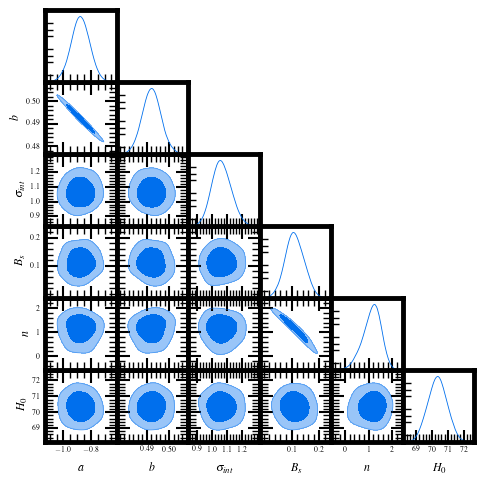

In [13]:
gdplot.triangle_plot(gdsamples, ["a","b","sv","omega_m", "n", "H0"], filled=True)

mean = gdsamples.getMeans()[:6]
sigma = np.sqrt(np.array(gdsamples.getVars()[:6]))
covmat = gdsamples.getCovMat().matrix[:6, :6]
plt. savefig("figures/combined.pdf", format="pdf", bbox_inches="tight")
print("Using "+ str(i) + " sigma")
print("Mean")
print(mean)
print("1 sigma:")
print(sigma)
print("Covariance matrix:")
print(covmat) 